# Tensor Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp) (with Marcos Treviso)





When learning a tensor programming language like PyTorch or Numpy it
is tempting to rely on the standard library (or more honestly
StackOverflow) to find a magic function for everything.  But in
practice, the tensor language is extremely expressive, and you can
do most things from first principles and clever use of broadcasting.



This is a collection of 21 tensor puzzles. Like chess puzzles these are
not meant to simulate the complexity of a real program, but to practice
in a simplified environment. Each puzzle asks you to reimplement one
function in the NumPy standard library without magic.


I recommend running in Colab. Click here and copy the notebook to get start.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/Tensor-Puzzles/blob/main/Tensor%20Puzzlers.ipynb)

In [ ]:
!pip install -qqq jaxtyping beartype hypothesis pytest git+https://github.com/chalk-diagrams/chalk

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%%writefile lib.py

from hypothesis.extra.numpy import arrays
from hypothesis.strategies import integers, booleans, lists, composite, floats
from hypothesis import given
import numpy as np
import random
import sys
import inspect
import typing
import matplotlib.pyplot as plt

import urllib
import torch
import time
from chalk import *
import chalk
from colour import Color
from IPython.display import display, SVG
import jaxtyping

class JaxTensor:
    def __init__(self, TyArg):
        self.Ty = TyArg

    def __getitem__(self, s):
        return self.Ty[torch.Tensor, s]

# In Normal jaxtyping, a Torch Tensor array of shape (5, 6) would be written:
#   jaxtyping.Real[torch.Tensor, "5 6"]
# However, this is somewhat verbose for most of our usage, so we shorten this to:
#   Reals["5 6"]
Ints = JaxTensor(jaxtyping.Int)
Reals = JaxTensor(jaxtyping.Real)
Bools = JaxTensor(jaxtyping.Bool)


def jax_to_torch_type(ann: jaxtyping.AbstractArray) -> torch.dtype:
    """Return a torch dtype given a jaxtyping annotation."""
    # jaxtyping stores a list of acceptable dtypes.
    # Match the ~widest interpretation of a given jaxtyping.ArrayDType.
    # https://pytorch.org/docs/stable/tensor_attributes.html
    preference_list = [
        ("float32", torch.float32),  # 1.0 * torch.tensor([1,2,3]).dtype
        ("int64", torch.int64),      # torch.tensor([1,2,3]).dtype
        ("complex128", torch.complex128),
        ("complex64", torch.complex64),
        ("float64", torch.float64),
        ("bfloat16", torch.bfloat16),
        ("float16", torch.float16),
        ("uint64", torch.int64),
        ("int32", torch.int32),
        ("uint32", torch.int64),
        ("int16", torch.int16),
        ("uint16", torch.int32),
        ("int8", torch.int8),
        ("uint8", torch.uint8),
        ("bool", torch.bool),
        ("bool_", torch.bool),
    ]
    for (dtype_str, torch_type) in preference_list:
        if dtype_str in ann.dtypes:
            return torch_type
    print(f"I don't understand how to make a torch.tensor of jaxtyping dtype {ann}")
    assert False

tensor = torch.tensor

numpy_to_torch_dtype_dict = {
    bool: torch.bool,
    np.uint8: torch.uint8,
    np.int8: torch.int8,
    np.int16: torch.int16,
    np.int32: torch.int32,
    np.int64: torch.int64,
    np.float16: torch.float16,
    np.float32: torch.float32,
    np.float64: torch.float64,
}
torch_to_numpy_dtype_dict = {v: k for k, v in numpy_to_torch_dtype_dict.items()}


color = [Color("red")] * 50

def color(v):
    d = rectangle(1, 1)
    if v == 0:
        return d
    elif v > 0:
        return d.fill_color(Color("orange")).fill_opacity(0.4 + 0.6 *( v / 10))
    elif v < 0:
        return d.fill_color(Color("blue")).fill_opacity(0.4 + 0.6 * ( abs(v) / 10))

def draw_matrix(mat):
    return vcat((hcat((color(v)
                       for j, v in enumerate(inner)))
     for i, inner in enumerate(mat)))

def grid(diagrams):
    mhs = [0] * 100
    mws = [0] * 100
    for i, row in enumerate(diagrams):
        mh = 0
        for j, col in enumerate(row):
            env = col.get_envelope()
            mhs[i] = max(env.height, mhs[i])
            mws[j] = max(mws[j], env.width)
    return vcat([hcat([col.center_xy().with_envelope(rectangle(mws[j], mhs[i]))
                       for j, col in enumerate(row)], 1.0) for i, row in enumerate(diagrams)], 1.0)

def draw_example(data):
    name = data["name"]
    keys = list(data["vals"][0].keys())
    # cols = [[vstrut(0)] + [vstrut(0.5) / text(f"Ex. {i}", 0.5).fill_color(Color("black")).line_width(0.0) / vstrut(0.5) for i in range(len(data["vals"]))]]
    cols = []
    for k in keys:
        mat = [(vstrut(0.5) / text(k, 0.5).fill_color(Color("black")).line_width(0.0) / vstrut(0.5))]
        for ex in data["vals"]:
            v2 = ex[k]
            mat.append(draw_matrix(v2))
        cols.append(mat)

    full = grid(cols)

    full = (
        vstrut(1)
        / text(name, 0.75).fill_color(Color("black")).line_width(0)
        / vstrut(1)
        / full.center_xy()
    )
    full = full.pad(1.2).center_xy()
    env = full.get_envelope()
    set_svg_height(50 * env.height)
    height = 50 * env.height
    chalk.set_svg_height(300)
    return rectangle(env.width, env.height).fill_color(Color("white")) + full

def draw_examples(name, examples):
    data = {"name":name,
                  "vals" :[{k: [v.tolist()] if len(v.shape) == 1 else v.tolist()
                        for k, v in example.items()}
                        for example in examples ] }
    return draw_example(data)


@composite
def spec(draw, x, min_size=1):
    # Get the type hints.
    if sys.version_info >= (3, 9):
        gth = typing.get_type_hints(x, include_extras=True)
    else:
        gth = typing.get_type_hints(x)

    # Collect all the dimension names.
    names = {}
    for k in gth:
        if issubclass(gth[k], int):
            names[k] = None
        elif issubclass(gth[k], jaxtyping.AbstractArray):
            names = names | dict.fromkeys([d.name for d in gth[k].dims if hasattr(d, 'name')])
        else:
            print(f"Ignoring param {k} with type {gth[k]}")
    names = list(names.keys())

    # draw sizes for each dim.
    size = integers(min_value=min_size, max_value=5)
    arr = draw(arrays(shape=(len(names),), unique=True, elements=size, dtype=np.int32)).tolist()
    sizes = dict(zip(names, arr))

    # Create tensors for each size.
    ret = {}
    for k in gth:
        if not issubclass(gth[k], jaxtyping.AbstractArray):
            continue
        # jaxtyping style type
        dims = []
        for d in gth[k].dims:
            if hasattr(d, 'name'):
                dims.append(sizes[d.name])
            elif hasattr(d, 'size'):
                dims.append(d.size)
            elif hasattr(d, 'elem'):
                # This is approximately what jaxtyping does.
                # Support f-string syntax.
                # https://stackoverflow.com/a/53671539/22545467
                elem = eval(f"f'{d.elem}'", sizes.copy())
                dim = eval(elem, sizes.copy())
                dims.append(int(dim))
        shape = tuple(dims)
        torch_dtype = jax_to_torch_type(gth[k])
        np_dtype = torch_to_numpy_dtype_dict[torch_dtype]
        ret[k] = draw(
            arrays(
                shape=shape,
                dtype=np_dtype,
                elements=(booleans() if torch_dtype == torch.bool else
                          floats(min_value=-1e10, max_value=1e10, width=32) if torch_dtype.is_floating_point else
                          integers(min_value=-5, max_value=5)),
                unique=False
            )
        )
        ret[k] = np.nan_to_num(ret[k], nan=0, neginf=0, posinf=0)

    ret["return"][:] = 0
    return ret, sizes


def mk_tensor_args(fn, example_args):
    """Prepare an ordered set of example_args so that all non-scalars are torch.tensors.

    Arguments:
      fn:  the function to which the args are to be passed.
      example_args:  array like parameters.

    Returns:
      a list of arguments in torch.tensor format, suitable for passing to fn
    """
    params = list(inspect.signature(fn).parameters.values())
    args = []
    for (param, v) in zip(params, example_args.values()):
        if isinstance(param.annotation, type) and issubclass(param.annotation, (int, float)):
            args.append(v)
        elif issubclass(param.annotation, jaxtyping.AbstractArray):
            torch_dtype = jax_to_torch_type(param.annotation)
            args.append(torch.tensor(v, dtype=torch_dtype))
        else:
            args.append(torch.tensor(v))
    return args


def make_test(name, problem, problem_spec, add_sizes=[], constraint=lambda d: d):
    examples = []
    for i in range(3):
        example, sizes = spec(problem, 3).example()
        example = constraint(example)
        out = example["return"].tolist()
        del example["return"]
        problem_spec(*example.values(), out)

        for size in add_sizes:
            example[size] = sizes[size]

        yours = None
        try:
            yours = problem(*mk_tensor_args(problem, example))

        except NotImplementedError:
            pass
        for size in add_sizes:
            del example[size]
        example["target"] = tensor(out)
        if yours is not None:
            example["yours"] = yours
        examples.append(example)

    diagram = draw_examples(name, examples)
    display(SVG(diagram._repr_svg_()))

    @given(spec(problem))
    def test_problem(d):
        d, sizes = d
        d = constraint(d)
        out = d["return"].tolist()
        expected_torch_return_dtype = numpy_to_torch_dtype_dict[d["return"].dtype.type]
        del d["return"]
        problem_spec(*d.values(), out)
        for size in add_sizes:
            d[size] = sizes[size]

        out2 = problem(*mk_tensor_args(problem, d))
        out = tensor(out, dtype=expected_torch_return_dtype)
        out2 = torch.broadcast_to(out2, out.shape)
        assert torch.allclose(
            out, out2, atol=1e-7
        ), "Two tensors are not equal\n Spec: \n\t%s \n\t%s" % (out, out2)

    return test_problem


def run_test(fn):
    fn()
    # Generate a random puppy video if you are correct.
    print("Correct!")

Overwriting lib.py


In [ ]:
from lib import draw_examples, make_test, run_test
import torch
import numpy as np
import jaxtyping
from jaxtyping import Float32, Int, Bool
from torch import Tensor

tensor = torch.tensor

## Rules

1. These puzzles are about *broadcasting*. Know this rule.

![](https://pbs.twimg.com/media/FQywor0WYAssn7Y?format=png&name=large)

2. Each puzzle needs to be solved in 1 line (<80 columns) of code.
3. You are allowed @, arithmetic, comparison, `shape`, any indexing (e.g. `a[:j], a[:, None], a[arange(10)]`), and previous puzzle functions.
4. You are *not allowed* anything else. No `view`, `sum`, `take`, `squeeze`, `tensor`.

5. You can start with these two functions:

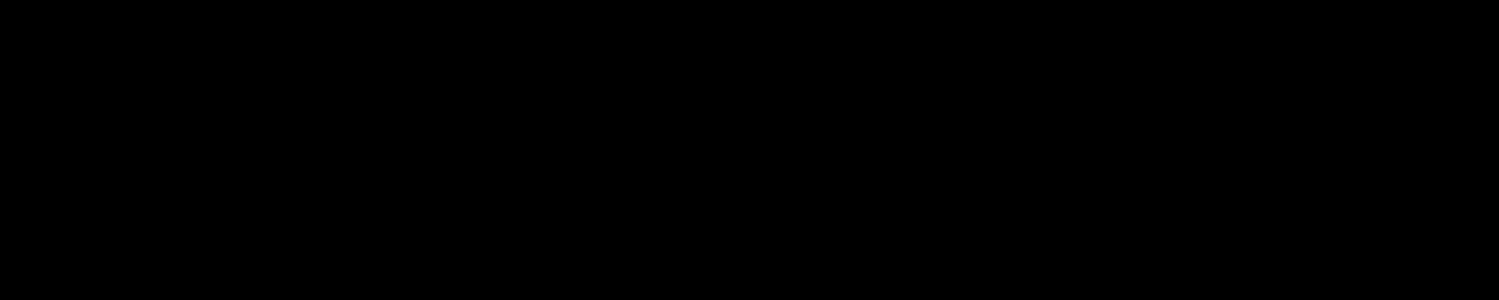

In [ ]:
def arange(i: int):
    "Use this function to replace a for-loop."
    return torch.tensor(range(i))

draw_examples("arange", [{"" : arange(i)} for i in [5, 3, 9]])

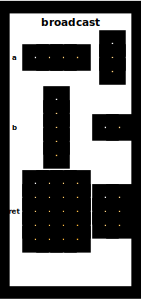

In [ ]:
# Example of broadcasting.
examples = [(arange(4), arange(5)[:, None]) ,
            (arange(3)[:, None], arange(2))]
draw_examples("broadcast", [{"a": a, "b":b, "ret": a + b} for a, b in examples])

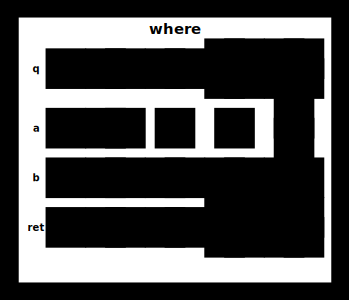

In [ ]:
def where(q, a, b):
    "Use this function to replace an if-statement."
    return (q * a) + (~q) * b

# In diagrams, orange is positive/True, white is zero/False, and blue is negative.

examples = [(tensor([False]), tensor([10]), tensor([0])),
            (tensor([False, True]), tensor([1, 1]), tensor([-10, 0])),
            (tensor([False, True]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([[0], [10]]), tensor([-10, 0])),
           ]
draw_examples("where", [{"q": q, "a":a, "b":b, "ret": where(q, a, b)} for q, a, b in examples])

## Puzzle 1 - ones

Compute [ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) - the vector of all ones.

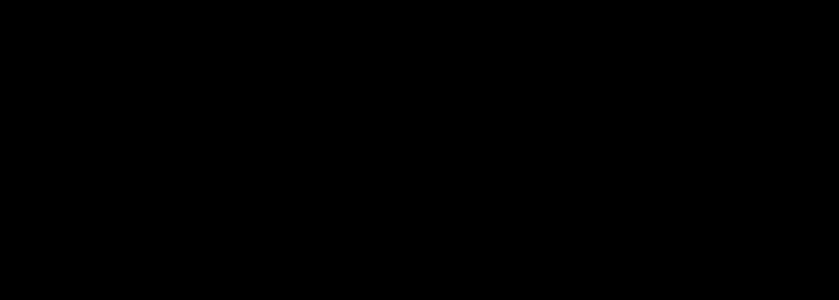

In [ ]:
def ones_spec(out):
    for i in range(len(out)):
        out[i] = 1

def ones(i: int) -> Int[Tensor, "i"]:
    return where(arange(i) > -1, 1, 0)

test_ones = make_test("one", ones, ones_spec, add_sizes=["i"])

In [ ]:
run_test(test_ones)

Correct!


## Puzzle 2 - sum

Compute [sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) - the sum of a vector.

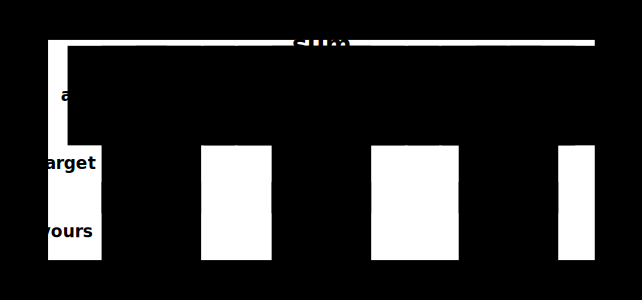

In [ ]:
def sum_spec(a, out):
    out[0] = 0
    for i in range(len(a)):
        out[0] += a[i]

def sum(a: Int[Tensor, "i"]) -> Int[Tensor, '1']:
    return ones(a.shape[0]) @ a[:, None]


test_sum = make_test("sum", sum, sum_spec)

In [ ]:
run_test(test_sum)

Correct!


## Puzzle 3 - outer

Compute [outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) - the outer product of two vectors.

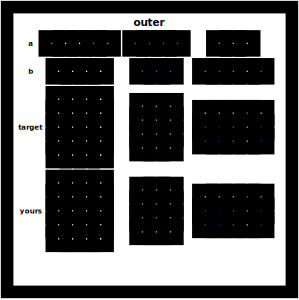

In [ ]:
def outer_spec(a, b, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            out[i][j] = a[i] * b[j]

def outer(a: Int[Tensor, "i"], b: Int[Tensor, "j"]) -> Int[Tensor, "i j"]:
    return a[:, None] * b[None, :]

test_outer = make_test("outer", outer, outer_spec)

In [ ]:
run_test(test_outer)

Correct!


## Puzzle 4 - diag

Compute [diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) - the diagonal vector of a square matrix.

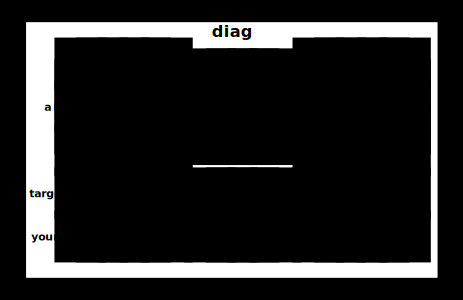

In [ ]:
def diag_spec(a, out):
    for i in range(len(a)):
        out[i] = a[i][i]

def diag(a: Int[Tensor, "i i"]) -> Int[Tensor, "i"]:
    return a[arange(a.shape[0]), arange(a.shape[0])]


test_diag = make_test("diag", diag, diag_spec)

In [ ]:
run_test(test_diag)

Correct!


## Puzzle 5 - eye

Compute [eye](https://numpy.org/doc/stable/reference/generated/numpy.eye.html) - the identity matrix.

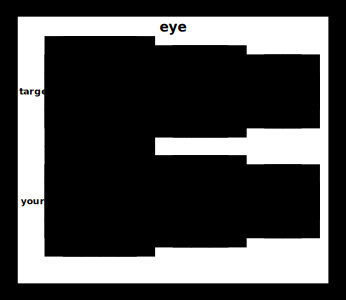

In [ ]:
def eye_spec(out):
    for i in range(len(out)):
        out[i][i] = 1

def eye(j: int) -> Int[Tensor, "j j"]:
    return 1 * (arange(j)[:, None] == arange(j))   # broadcast & dtype cast

test_eye = make_test("eye", eye, eye_spec, add_sizes=["j"])

In [ ]:
run_test(test_eye)

Correct!


## Puzzle 6 - triu

Compute [triu](https://numpy.org/doc/stable/reference/generated/numpy.triu.html) - the upper triangular matrix.

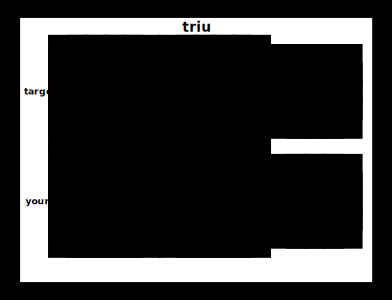

In [ ]:
def triu_spec(out):
    for i in range(len(out)):
        for j in range(len(out)):
            if i <= j:
                out[i][j] = 1
            else:
                out[i][j] = 0

def triu(j: int) -> Int[Tensor, "j j"]:
    return 1 * (arange(j)[:, None] <= arange(j))


test_triu = make_test("triu", triu, triu_spec, add_sizes=["j"])

In [ ]:
run_test(test_triu)

Correct!


## Puzzle 7 - cumsum

Compute [cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) - the cumulative sum.

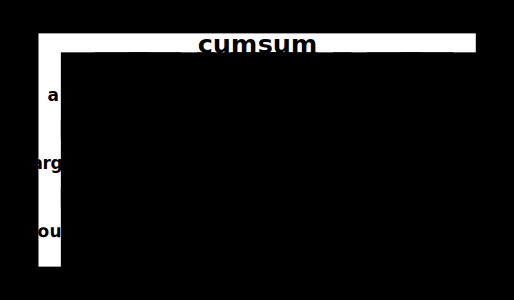

In [ ]:
def cumsum_spec(a, out):
    total = 0
    for i in range(len(out)):
        out[i] = total + a[i]
        total += a[i]

def cumsum(a: Int[Tensor, "i"]) -> Int[Tensor, "i"]:
    i = a.shape[0]
    return a @ (where(arange(i)[:, None] <= arange(i), 1, 0))

test_cumsum = make_test("cumsum", cumsum, cumsum_spec)

In [ ]:
run_test(test_cumsum)

Correct!


## Puzzle 8 - diff

Compute [diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) - the running difference.

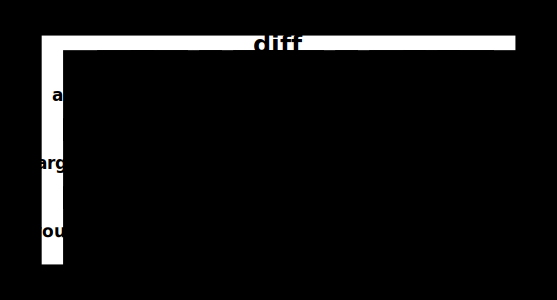

In [ ]:
def diff_spec(a, out):
    out[0] = a[0]
    for i in range(1, len(out)):
        out[i] = a[i] - a[i - 1]

def diff(a: Int[Tensor, "i"], i: int) -> Int[Tensor, "i"]:
    return a[arange(i)] - where(arange(i) != 0, a[arange(i)-1], 0)

test_diff = make_test("diff", diff, diff_spec, add_sizes=["i"])

In [ ]:
run_test(test_diff)

Correct!


## Puzzle 9 - vstack

Compute [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) - the matrix of two vectors

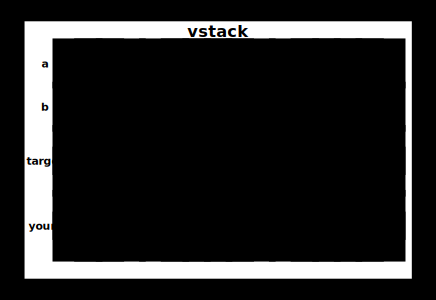

In [ ]:
def vstack_spec(a, b, out):
    for i in range(len(out[0])):
        out[0][i] = a[i]
        out[1][i] = b[i]

def vstack(a: Int[Tensor, "i"], b: Int[Tensor, "i"]) -> Int[Tensor, "2 i"]:
    i = a.shape[0]
    return where(arange(2)[:, None] == ones(i), b, a)


test_vstack = make_test("vstack", vstack, vstack_spec)

In [ ]:
run_test(test_vstack)

Correct!


## Puzzle 10 - roll

Compute [roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) - the vector shifted 1 circular position.

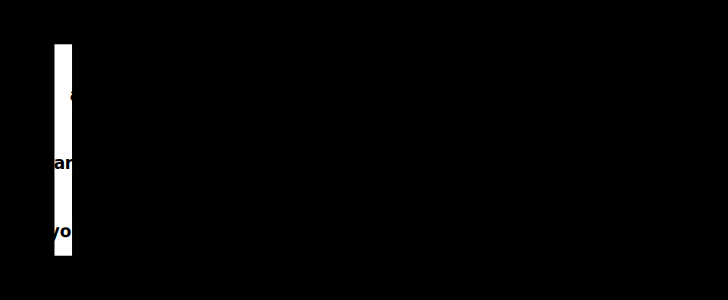

In [ ]:
def roll_spec(a, out):
    for i in range(len(out)):
        if i + 1 < len(out):
            out[i] = a[i + 1]
        else:
            out[i] = a[i + 1 - len(out)]

def roll(a: Int[Tensor, "i"], i: int) -> Int[Tensor, "i"]:
    return a[(arange(i) + 1) % i]


test_roll = make_test("roll", roll, roll_spec, add_sizes=["i"])

In [ ]:
run_test(test_roll)

Correct!


## Puzzle 11 - flip

Compute [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html) - the reversed vector

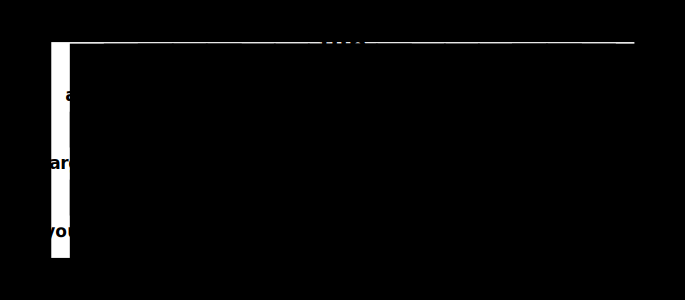

In [ ]:
def flip_spec(a, out):
    for i in range(len(out)):
        out[i] = a[len(out) - i - 1]

def flip(a: Int[Tensor, "i"], i: int) -> Int[Tensor, "i"]:
    return a[i - arange(i) -1]


test_flip = make_test("flip", flip, flip_spec, add_sizes=["i"])

In [ ]:
run_test(test_flip)

Correct!


## Puzzle 12 - compress


Compute [compress](https://numpy.org/doc/stable/reference/generated/numpy.compress.html) - keep only masked entries (left-aligned).

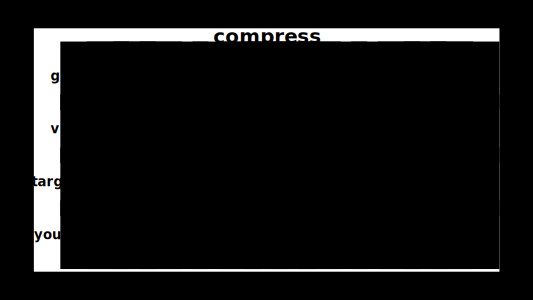

In [ ]:
def compress_spec(g, v, out):
    j = 0
    for i in range(len(g)):
        if g[i]:
            out[j] = v[i]
            j += 1

def compress(g: Bool[Tensor, "i"], v: Int[Tensor, "i"], i:int) -> Int[Tensor, "i"]:
    return v @ where(g[:, None], arange(i) == (cumsum(1 * g) - 1)[:, None], 0)


test_compress = make_test("compress", compress, compress_spec, add_sizes=["i"])

In [ ]:
run_test(test_compress)

Correct!


## Puzzle 13 - pad_to


Compute pad_to - eliminate or add 0s to change size of vector.

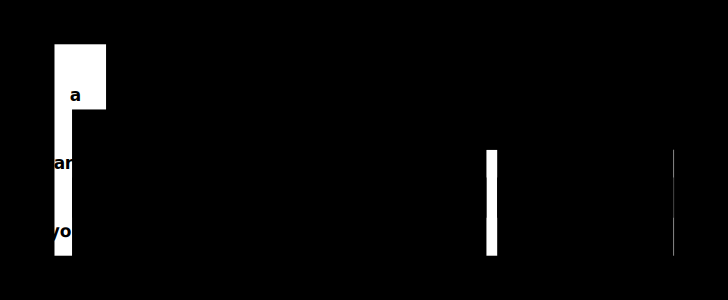

In [ ]:
def pad_to_spec(a, out):
    for i in range(min(len(out), len(a))):
        out[i] = a[i]


def pad_to(a: Int[Tensor, "i"], i: int, j: int) -> Int[Tensor, "j"]:
    return a @ (1 * (arange(i)[:, None] == arange(j)))


test_pad_to = make_test("pad_to", pad_to, pad_to_spec, add_sizes=["i", "j"])

In [ ]:
run_test(test_pad_to)

Correct!


## Puzzle 14 - sequence_mask


Compute [sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) - pad out to length per batch.

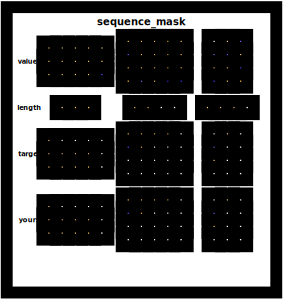

In [ ]:
def sequence_mask_spec(values, length, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            if j < length[i]:
                out[i][j] = values[i][j]
            else:
                out[i][j] = 0

def sequence_mask(values: Int[Tensor, "i j"], length: Int[Tensor, "i"]) -> Int[Tensor, "i j"]:
    i, j = values.shape
    return where(length[:, None] > arange(j), values, 0)


def constraint_set_length(d):
    d["length"] = d["length"] % d["values"].shape[1]
    return d


test_sequence = make_test("sequence_mask",
    sequence_mask, sequence_mask_spec, constraint=constraint_set_length
)

In [ ]:
run_test(test_sequence)

Correct!


## Puzzle 15 - bincount

Compute [bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) - count number of times an entry was seen.

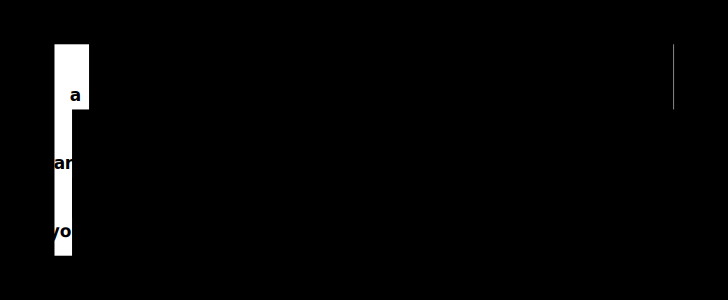

In [ ]:
def bincount_spec(a, out):
    for i in range(len(a)):
        out[a[i]] += 1

def bincount(a: Int[Tensor, "i"], j: int) -> Int[Tensor, "j"]:
    return ones(a.shape[0]) @ eye(j)[a]


def constraint_set_max(d):
    d["a"] = d["a"] % d["return"].shape[0]
    return d


test_bincount = make_test("bincount",
    bincount, bincount_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [ ]:
run_test(test_bincount)

Correct!


## Puzzle 16 - scatter_add

Compute [scatter_add](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html) - add together values that link to the same location.

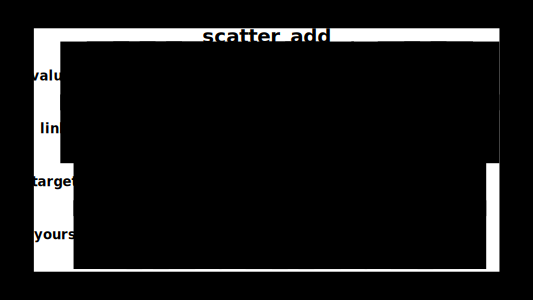

In [ ]:
def scatter_add_spec(values, link, out):
    for j in range(len(values)):
        out[link[j]] += values[j]

def scatter_add(values: Int[Tensor, "i"], link: Int[Tensor, "i"], j: int) -> Int[Tensor, "j"]:
    return values @ eye(j)[link]


def constraint_set_max(d):
    d["link"] = d["link"] % d["return"].shape[0]
    return d


test_scatter_add = make_test("scatter_add",
    scatter_add, scatter_add_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [ ]:
run_test(test_scatter_add)

Correct!


## Puzzle 17 - flatten

Compute [flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html)

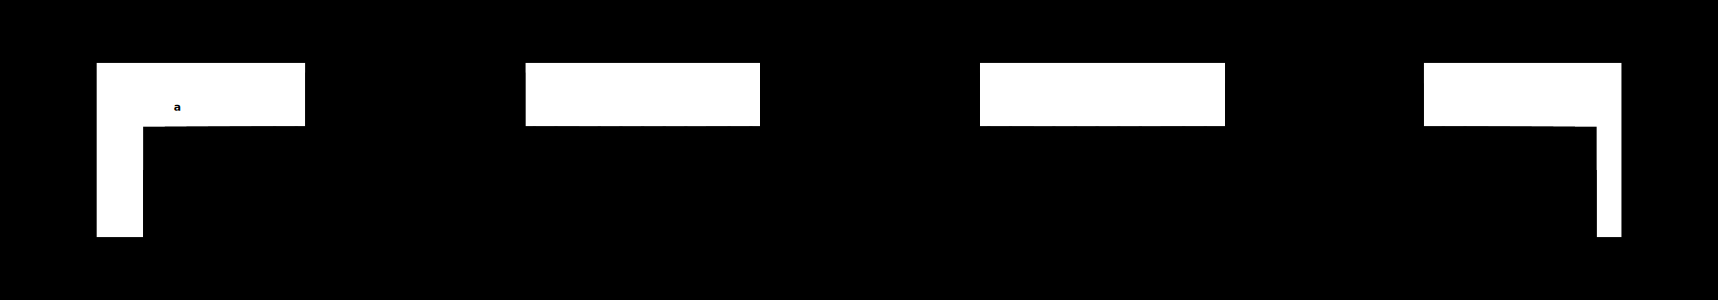

In [ ]:
def flatten_spec(a, out):
    k = 0
    for i in range(len(a)):
        for j in range(len(a[0])):
            out[k] = a[i][j]
            k += 1

def flatten(a: Int[Tensor, "i j"], i:int, j:int) -> Int[Tensor, "i*j"]:
    return a[arange(i * j) // j, arange(i * j) % j]

test_flatten = make_test("flatten", flatten, flatten_spec, add_sizes=["i", "j"])

In [ ]:
run_test(test_flatten)

Correct!


## Puzzle 18 - linspace

Compute [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)

<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))


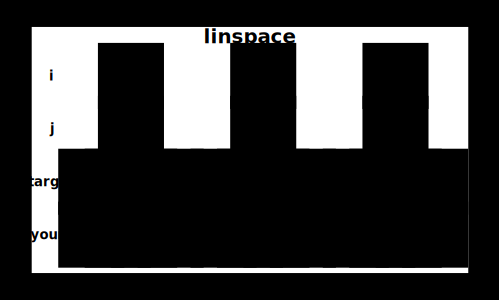

In [ ]:
def linspace_spec(i, j, out):
    for k in range(len(out)):
        out[k] = float(i + (j - i) * k / max(1, len(out) - 1))

def linspace(i: Int[Tensor, '1'], j: Int[Tensor, '1'], n: int) -> Float32[Tensor, "n"]:
    return (i + (j - i) * arange(n) / max(1, n-1))

test_linspace = make_test("linspace", linspace, linspace_spec, add_sizes=["n"])

In [ ]:
run_test(test_linspace)

<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conver

Correct!


<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-74-8670cd7ccbf5>:3: DeprecationWarning: Conver

## Puzzle 19 - heaviside

Compute [heaviside](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html)

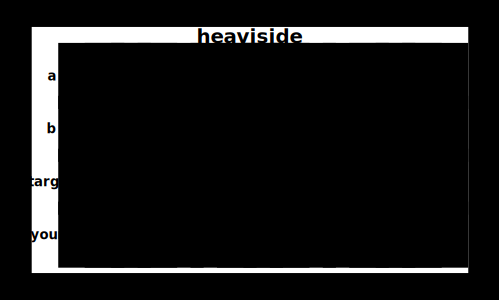

In [ ]:
def heaviside_spec(a, b, out):
    for k in range(len(out)):
        if a[k] == 0:
            out[k] = b[k]
        else:
            out[k] = int(a[k] > 0)

def heaviside(a: Int[Tensor, "i"], b: Int[Tensor, "i"]) -> Int[Tensor, "i"]:
    return where(a == 0, b, (a > 0) * 1)

test_heaviside = make_test("heaviside", heaviside, heaviside_spec)

In [ ]:
run_test(test_heaviside)

Correct!


## Puzzle 20 - repeat (1d)

Compute [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html)

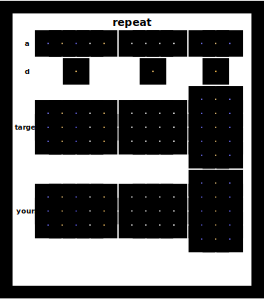

In [ ]:
def repeat_spec(a, d, out):
    for i in range(d[0]):
        for k in range(len(a)):
            out[i][k] = a[k]

def constraint_set(d):
    d["d"][0] = d["return"].shape[0]
    return d


def repeat(a: Int[Tensor, "i"], d: Int[Tensor, '1']) -> Int[Tensor, "d i"]:
    # return where(ones(d[0])[:, None], a, 0)
    # return ones(d[0])[:, None] * a
    return outer(ones(d[0]), a)

test_repeat = make_test("repeat", repeat, repeat_spec, constraint=constraint_set)



In [ ]:
run_test(test_repeat)

Correct!


 ## Puzzle 21 - bucketize

 Compute [bucketize](https://pytorch.org/docs/stable/generated/torch.bucketize.html)

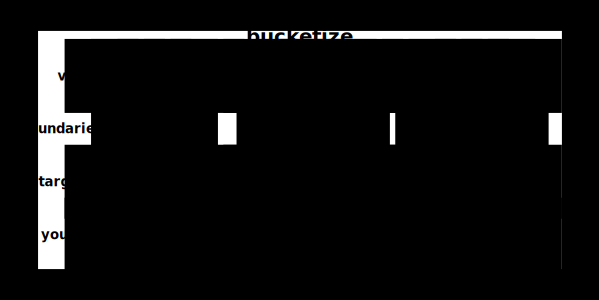

In [ ]:
def bucketize_spec(v, boundaries, out):
    for i, val in enumerate(v):
        out[i] = 0
        for j in range(len(boundaries)-1):
            if val >= boundaries[j]:
                out[i] = j + 1
        if val >= boundaries[-1]:
            out[i] = len(boundaries)


def constraint_set(d):
    d["boundaries"] = np.abs(d["boundaries"]).cumsum()
    return d


def bucketize(v: Int[Tensor, "i"], boundaries: Int[Tensor, "j"]) -> Int[Tensor, "i"]:
    return (1 * (v[:, None] >= boundaries )) @ ones(boundaries.shape[0])

test_bucketize = make_test("bucketize", bucketize, bucketize_spec,
                           constraint=constraint_set)





# Speed Run Mode!

What is the smallest you can make each of these?

In [ ]:
import inspect
fns = (ones, sum, outer, diag, eye, triu, cumsum, diff, vstack, roll, flip,
       compress, pad_to, sequence_mask, bincount, scatter_add)

for fn in fns:
    lines = [l for l in inspect.getsource(fn).split("\n") if not l.strip().startswith("#")]

    if len(lines) > 3:
        print(fn.__name__, len(lines[2]), "(more than 1 line)")
    else:
        print(fn.__name__, len(lines[1]))

ones 38
sum 40
outer 34
diag 52
eye 75
triu 48
cumsum 61 (more than 1 line)
diff 67
vstack 53 (more than 1 line)
roll 33
flip 30
compress 78
pad_to 54
sequence_mask 60 (more than 1 line)
bincount 39
scatter_add 32
